In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul  7 14:54:53 2021

@author: Patrick
"""

def open_pickle(path_in, file_name):
    import pickle
    tmp = pickle.load(open(path_in + file_name, "rb"))
    return tmp

def write_pickle(path_in, file_name, var_in):
    import pickle
    pickle.dump(var_in, open(path_in + file_name, "wb"))

def vec_fun(df_in, path_in):
    from sklearn.feature_extraction.text import CountVectorizer
    import pandas as pd
    my_vec = CountVectorizer()
    my_vec_text = pd.DataFrame(my_vec.fit_transform(df_in).toarray())
    my_vec_text.columns = my_vec.get_feature_names() 
    write_pickle(path_in, "vec.pkl", my_vec)
    return my_vec_text

def perf_metrics(model_in, x_in, y_true):
    from sklearn.metrics import precision_recall_fscore_support
    y_pred = model_in.predict(x_in)
    metrics = precision_recall_fscore_support(
        y_true, y_pred, average='weighted')
    return metrics

def my_rf(x_in, y_in, out_in):
    from sklearn.ensemble import RandomForestClassifier
    my_rf_m = RandomForestClassifier()
    my_rf_m.fit(x_in, y_in)
    write_pickle(out_in, "rf.pkl", my_rf_m)
    return my_rf_m

def split_data(x_in, y_in, split_fraction):
    from sklearn.model_selection import train_test_split
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
        x_in, y_in, test_size=(1.0 - split_fraction), random_state=42)
    return X_train_t, X_test_t, y_train_t, y_test_t

def my_pca(df_in, n_conp_in, path_in):
    from sklearn.decomposition import PCA
    pca_m = PCA(n_components = n_conp_in)
    pca_data_t = pca_m.fit_transform(df_in)
    write_pickle(path_in, "pca.pkl", pca_m)
    return pca_data_t

In [3]:
base_path = "/content/"
final_data = open_pickle(base_path, "data.pkl")

In [4]:
my_vec_text = vec_fun(final_data.body_basic, base_path)
pca_data = my_pca(my_vec_text,0.9, base_path)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PCA Compoents Curve

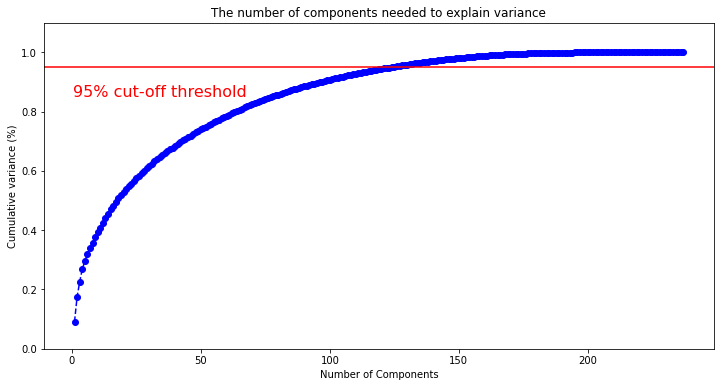

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(my_vec_text)
pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 238, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.show()

In [6]:
X=pca_data
y=final_data.label
X_train, X_test, y_train, y_test = split_data(X, y, 0.2)

Random Forest Train

In [7]:
from sklearn.metrics import classification_report
rf_model = my_rf(X_train, y_train, base_path)
predicted = rf_model.predict(X_test)
rf_report = classification_report(y_test, predicted)
print(rf_report)

                  precision    recall  f1-score   support

     fly_fishing       0.95      0.78      0.86        73
      ice_hockey       0.68      0.96      0.80        56
machine_learning       0.94      0.79      0.86        61

        accuracy                           0.84       190
       macro avg       0.86      0.84      0.84       190
    weighted avg       0.87      0.84      0.84       190



K-Fold Cross Validation

In [8]:
# evaluate the model
from numpy import mean,std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
n_scores = cross_val_score(rf_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Mean & Stdev Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print(f'Accuracy Scores for each fold: {n_scores}')

Mean & Stdev Accuracy: 0.890 (0.041)
Accuracy Scores for each fold: [0.89583333 0.85416667 0.87234043 0.89361702 0.93617021 0.9375
 0.8125     0.87234043 0.87234043 0.95744681]


Hyper Parameter Tunning

In [43]:
from sklearn.model_selection import GridSearchCV
n_estimators = [10,20,50,75,100]
max_depth = [3,4,5]
min_samples_split = [3,4,5]
min_samples_leaf = [3,4,5] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rf_model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
bestF.best_estimator_

Fitting 3 folds for each of 135 candidates, totalling 405 fits


RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=75)

In [45]:
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 5,
                                   n_estimators = 75, min_samples_split = 4,
                                   min_samples_leaf = 3)
                                   
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)
rf_report_tune = classification_report(y_test, y_pred)
print(rf_report_tune)

                  precision    recall  f1-score   support

     fly_fishing       0.97      0.77      0.85        73
      ice_hockey       0.65      0.96      0.78        56
machine_learning       0.96      0.77      0.85        61

        accuracy                           0.83       190
       macro avg       0.86      0.83      0.83       190
    weighted avg       0.87      0.83      0.83       190



Experimenting Different Models

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
report = classification_report(y_test, preds)
print(report)

                  precision    recall  f1-score   support

     fly_fishing       0.92      0.48      0.63        73
      ice_hockey       0.57      0.71      0.63        56
machine_learning       0.56      0.75      0.64        61

        accuracy                           0.64       190
       macro avg       0.68      0.65      0.64       190
    weighted avg       0.70      0.64      0.64       190



In [13]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
DecisionTreeClassifierScore = dtc.score(X_test,y_test)
print("Accuracy obtained by Decision Tree Classifier model:",DecisionTreeClassifierScore*100)
y_pred_dtc = dtc.predict(X_test)
dt_report = classification_report(y_test, y_pred_dtc)
print(dt_report)

Accuracy obtained by Decision Tree Classifier model: 80.0
                  precision    recall  f1-score   support

     fly_fishing       0.90      0.73      0.80        73
      ice_hockey       0.72      0.95      0.82        56
machine_learning       0.81      0.75      0.78        61

        accuracy                           0.80       190
       macro avg       0.81      0.81      0.80       190
    weighted avg       0.82      0.80      0.80       190



After comparing model performance and hyper parameter tunning, random forest in general performs pretty well. Though the decision tree model did yield a better results for ice_hokey precision. 